https://habr.com/ru/articles/785474/

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Encoder

## Positional encoding

In [ ]:
MAX_SEQ_LEN = 500
EMB_SIZE = 128
encoding = torch.zeros(MAX_SEQ_LEN, EMB_SIZE)
position = torch.arange(0, MAX_SEQ_LEN).unsqueeze(1)
encoding.shape, position.shape

(torch.Size([500, 128]), torch.Size([500, 1]))

In [ ]:
i = torch.arange(0, EMB_SIZE, 2)
div_term = torch.pow(10000.0, -2*i/EMB_SIZE)
position = torch.arange(0, MAX_SEQ_LEN).unsqueeze(1)

enc_even = torch.sin(position * div_term)
encoding[:, 0::2] = torch.sin(position * div_term)
encoding[:, 1::2] = torch.cos(position * div_term)
div_term.shape, encoding.shape

(torch.Size([64]), torch.Size([500, 128]))

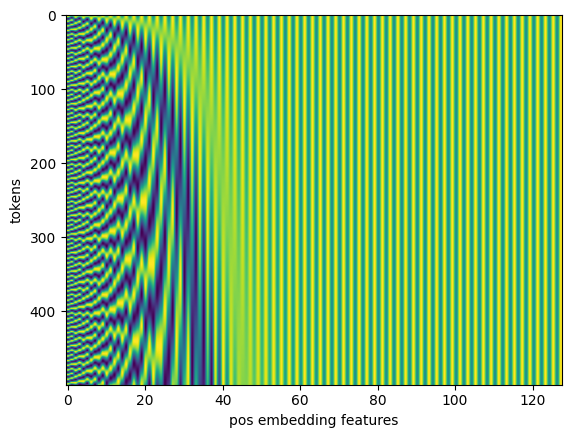

In [ ]:
plt.imshow(encoding.numpy(), aspect='auto')
plt.xlabel('pos embedding features')
plt.ylabel('tokens')
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len=5000):
        super().__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        i = torch.arange(0, emb_size, 2)
        div_term = torch.pow(10000.0, -2*i/emb_size)

        self.encoding = torch.zeros(max_len, emb_size)
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding

    def forward(self, emb):
        return emb + self.encoding[:emb.size(-2)].detach()

## Generate input sequence

In [ ]:
# generate vocabulary embedding space
# let first embedding be <BOS> token embedding filled with 0s
# let second embedding be <EOS> token embedding filled with 1s

VOCAB_SIZE = 128
EMB_SIZE = 4
BOS_ID = 0
EOS_ID = 1

emb_vocab = torch.rand(VOCAB_SIZE + 2, EMB_SIZE)
emb_vocab[BOS_ID] = torch.zeros(EMB_SIZE)
emb_vocab[EOS_ID] = torch.ones(EMB_SIZE)

In [ ]:
emb_vocab[BOS_ID], emb_vocab[EOS_ID]

(tensor([0., 0., 0., 0.]), tensor([1., 1., 1., 1.]))

In [ ]:
# generate dummy sequence of embeddings
# set first embedding to <BOS> token embedding
# set last embedding to <EOS> token embedding

SEQ_LEN = 5 # < MAX_LEN

input_seq = torch.rand(SEQ_LEN, EMB_SIZE)
input_seq[0] = emb_vocab[BOS_ID]
input_seq[-1] = emb_vocab[EOS_ID]
input_seq

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.2494, 0.0301, 0.5444, 0.1140],
        [0.3881, 0.8573, 0.4028, 0.7710],
        [0.6216, 0.0674, 0.0645, 0.6514],
        [1.0000, 1.0000, 1.0000, 1.0000]])

In [ ]:
# add positional encoding to the embeddings

pos_encoding = PositionalEncoding(EMB_SIZE, MAX_SEQ_LEN)
input_seq = pos_encoding(input_seq)
input_seq

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 1.0909,  0.5704,  0.5445,  1.1140],
        [ 1.2974,  0.4412,  0.4030,  1.7710],
        [ 0.7627, -0.9225,  0.0648,  1.6514],
        [ 0.2432,  0.3464,  1.0004,  2.0000]])

## Self-attention

In [ ]:
QKV_SIZE = 3 # QKV_SIZE < EMB_SIZE
NUM_HEADS = 2

WQ1 = torch.rand(EMB_SIZE, QKV_SIZE)
WQ2 = torch.rand(EMB_SIZE, QKV_SIZE)

WK1 = torch.rand(EMB_SIZE, QKV_SIZE)
WK2 = torch.rand(EMB_SIZE, QKV_SIZE)

WV1 = torch.rand(EMB_SIZE, QKV_SIZE)
WV2 = torch.rand(EMB_SIZE, QKV_SIZE)

# TODO: MATMUL ALONG AXIS (FOR SPLIT HEADS)
# WQ = torch.rand(NUM_HEADS, EMB_SIZE, QKV_SIZE)
# WK = torch.rand(NUM_HEADS, EMB_SIZE, QKV_SIZE)
# WV = torch.rand(NUM_HEADS, EMB_SIZE, QKV_SIZE)

In [ ]:
Q1 = input_seq @ WQ1
Q1

tensor([[1.0520, 0.7489, 0.1814],
        [2.2640, 1.4739, 0.6444],
        [2.4554, 1.6481, 0.5533],
        [0.6734, 0.3877, 0.0493],
        [2.1047, 0.9999, 0.9719]])

In [ ]:
K1 = input_seq @ WK1
K1

tensor([[0.4007, 0.5823, 0.8182],
        [1.1962, 2.0986, 2.0904],
        [1.4417, 2.4750, 2.5317],
        [0.8525, 1.5346, 1.4553],
        [1.1562, 2.2594, 2.1119]])

In [ ]:
V1 = input_seq @ WV1
V1

tensor([[ 1.3562,  1.0664,  0.7672],
        [ 2.2298,  1.0499,  1.3816],
        [ 2.7148,  1.1352,  1.5631],
        [ 1.1835, -0.2192,  0.5741],
        [ 2.2098,  0.8050,  1.6012]])

In [ ]:
enc_attn1_scores = Q1 @ K1.T / np.sqrt(QKV_SIZE)
enc_attn1_scores.shape

torch.Size([5, 5])

In [ ]:
enc_attn1_scores = F.softmax(enc_attn1_scores, dim=1)
enc_attn1_scores

tensor([[0.0644, 0.2297, 0.3285, 0.1366, 0.2408],
        [0.0129, 0.2125, 0.4753, 0.0662, 0.2331],
        [0.0106, 0.2090, 0.4874, 0.0613, 0.2317],
        [0.1122, 0.2225, 0.2696, 0.1685, 0.2272],
        [0.0168, 0.2168, 0.4649, 0.0722, 0.2293]])

In [ ]:
enc_attn1_emb = enc_attn1_scores @ V1
enc_attn1_emb.shape # [seq_len, qvk_size]

torch.Size([5, 3])

In [ ]:
class Attention(nn.Module):
    def __init__(self, emb_size, qkv_size):
        super().__init__()
        self.WQ = torch.rand(emb_size, qkv_size)
        self.WK = torch.rand(emb_size, qkv_size)
        self.WV = torch.rand(emb_size, qkv_size)

    def forward(self, emb):
        Q = emb @ self.WQ
        K = emb @ self.WK
        V = emb @ self.WV

        scores = K @ Q.T / np.sqrt(emb.size(-1))
        weights = F.softmax(scores, dim=1)
        attn_emb = weights @ V

        return attn_emb

In [ ]:
input_seq = torch.rand(SEQ_LEN, EMB_SIZE)

enc_attn1 = Attention(EMB_SIZE, QKV_SIZE)
enc_attn2 = Attention(EMB_SIZE, QKV_SIZE)

enc_attn1_emb = enc_attn1(input_seq)
enc_attn2_emb = enc_attn2(input_seq)

enc_attn_emb_cat = torch.cat([enc_attn1_emb, enc_attn2_emb], axis=1)

print(enc_attn1_emb.shape) # [seq_len, qvk_size]
enc_attn_emb_cat.shape # [seq_len, qvk_size x n_heads]

torch.Size([5, 3])


torch.Size([5, 6])

In [ ]:
W = torch.rand(QKV_SIZE*NUM_HEADS, EMB_SIZE)
enc_attn_emb = enc_attn_emb_cat @ W
enc_attn_emb.shape # [seq_len, emb_size]

torch.Size([5, 4])

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, AttentionClass, emb_size, qkv_size, num_heads):
        super().__init__()
        self.attn_heads = [AttentionClass(emb_size, qkv_size) for _ in range(num_heads)]
        self.W = torch.rand(qkv_size * num_heads, emb_size)

    def forward(self, *embs):
        attn_embs = []
        for attn_head in self.attn_heads:
            attn_embs.append(attn_head(*embs))
        attn_emb_cat = torch.cat(attn_embs, dim=1)
        attn_emb = attn_emb_cat @ self.W
        return attn_emb

In [ ]:
attn = MultiheadAttention(Attention, EMB_SIZE, QKV_SIZE, NUM_HEADS)
enc_attn_emb = attn(input_seq)
enc_attn_emb.shape

torch.Size([5, 4])

## Feed Forward

In [ ]:
class FeedForwardNet(nn.Module):
    def __init__(self, emb_size, linear_size):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, linear_size)
        self.nonlinear = nn.ReLU()
        self.fc2 = nn.Linear(linear_size, emb_size)

    def forward(self, emb):
        out = self.fc1(emb)
        out = self.nonlinear(out)
        out = self.fc2(out)
        return out

In [ ]:
LINEAR_SIZE = EMB_SIZE * 4

ff_net = FeedForwardNet(EMB_SIZE, LINEAR_SIZE)
logits = ff_net(enc_attn_emb)
logits.shape

torch.Size([5, 4])

## Encoder block

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, qkv_size, num_heads, linear_size):
        super().__init__()
        self.attn = MultiheadAttention(Attention, emb_size, qkv_size, num_heads)
        self.ff_net = FeedForwardNet(emb_size, linear_size)

    def forward(self, emb):
        attn_out = self.attn(emb)
        ff_out = self.ff_net(attn_out)
        return ff_out

class Encoder(nn.Module):
    def __init__(self, num_blocks, **kwargs):
        super().__init__()
        self.enc_blocks = [EncoderBlock(**kwargs)]

    def forward(self, emb):
        for enc_block in self.enc_blocks:
            emb = enc_block(emb)
        return emb

In [ ]:
enc_kwargs = dict(
    emb_size=EMB_SIZE,
    qkv_size=QKV_SIZE,
    num_heads=NUM_HEADS,
    linear_size=LINEAR_SIZE
)

encoder = Encoder(num_blocks=10, **enc_kwargs)
enc_out = encoder(input_seq)
enc_out

tensor([[-0.7945, -0.3825, -0.0074, -0.0149],
        [-0.7957, -0.3833, -0.0081, -0.0146],
        [-0.7936, -0.3824, -0.0073, -0.0152],
        [-0.8026, -0.3852, -0.0095, -0.0128],
        [-0.7958, -0.3832, -0.0079, -0.0146]], grad_fn=<AddmmBackward0>)

## Add + Layer Norm

In [ ]:
# Add attention embeddings
emb_added = (input_seq + enc_attn_emb)
enc_attn_emb.shape, input_seq.shape, enc_attn_emb.shape

(torch.Size([5, 4]), torch.Size([5, 4]), torch.Size([5, 4]))

In [ ]:
# Apply normalization along each feature
mean = emb_added.mean(dim=-1, keepdims=True)
std = emb_added.std(dim=-1, keepdims=True)
gamma = np.random.rand()
beta = np.random.rand()
emb_normed = (input_seq - mean) / std * gamma
emb_normed.shape

torch.Size([5, 4])

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = np.random.rand()
        self.beta = np.random.rand()

    def forward(self, emb):
        mean = emb.mean(dim=-1, keepdims=True)
        std = emb.std(dim=-1, keepdims=True)
        emb_normed = (emb - mean) / (std + self.eps)
        emb_normed *= self.gamma + self.beta
        return emb_normed

In [ ]:
layer_norm = LayerNorm()
emb_normed = layer_norm(input_seq + enc_attn_emb)
emb_normed.shape

torch.Size([5, 4])

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, qkv_size, num_heads, linear_size):
        super().__init__()
        self.attn = MultiheadAttention(Attention, emb_size, qkv_size, num_heads)
        self.layer_norm1 = LayerNorm()
        self.ff_net = FeedForwardNet(emb_size, linear_size)
        self.layer_norm2 = LayerNorm()

    def forward(self, source_seq):
        attn_out = self.attn(source_seq)
        source_seq = self.layer_norm1(source_seq + attn_out)
        ff_out = self.ff_net(source_seq)
        source_seq = self.layer_norm2(source_seq + ff_out)
        return source_seq

class Encoder(nn.Module):
    def __init__(self, num_blocks, **kwargs):
        super().__init__()
        self.enc_blocks = [EncoderBlock(**kwargs)]

    def forward(self, emb):
        for enc_block in self.enc_blocks:
            emb = enc_block(emb)
        return emb

In [ ]:
enc_kwargs = dict(
    emb_size=EMB_SIZE,
    qkv_size=QKV_SIZE,
    num_heads=NUM_HEADS,
    linear_size=LINEAR_SIZE
)

NUM_BLOCKS_ENC = 10
encoder = Encoder(num_blocks=NUM_BLOCKS_ENC, **enc_kwargs)
enc_out = encoder(input_seq)
enc_out

tensor([[ 1.5745, -0.1711,  0.5022, -1.9055],
        [ 1.1952, -0.6490,  1.2089, -1.7551],
        [ 1.8836, -0.6507,  0.2946, -1.5275],
        [ 0.8879, -1.6015,  1.5366, -0.8230],
        [ 1.2459, -0.2121,  0.9426, -1.9763]], grad_fn=<MulBackward0>)

# Decoder

## Generate target sequence

In [ ]:
# generate dummy TARGET embeddings
# let first embedding be <BOS> token embedding filled with 0s
# let last embedding be <EOS> token embedding filled with 1s

# let target sequence have couple words more than input
MAX_SEQ_LEN = 10
SEQ_LEN = 5 + 1 # < MAX_LEN

target_seq = torch.rand(SEQ_LEN, EMB_SIZE)
target_seq[0] = emb_vocab[BOS_ID]
target_seq[-1] = emb_vocab[EOS_ID]
input_seq.shape, target_seq.shape

(torch.Size([5, 4]), torch.Size([6, 4]))

## Masked self-attention

In [ ]:
# compute attention scores
WQ1 = torch.rand(EMB_SIZE, QKV_SIZE)
WQ2 = torch.rand(EMB_SIZE, QKV_SIZE)

WK1 = torch.rand(EMB_SIZE, QKV_SIZE)
WK2 = torch.rand(EMB_SIZE, QKV_SIZE)

WV1 = torch.rand(EMB_SIZE, QKV_SIZE)
WV2 = torch.rand(EMB_SIZE, QKV_SIZE)

Q1 = target_seq @ WQ1
K1 = target_seq @ WK1
V1 = target_seq @ WV1

dec_attn1_scores = K1 @ Q1.T / np.sqrt(QKV_SIZE)

In [ ]:
# mask attention scores for future tokens
target_seq_len = dec_attn1_scores.size(1)
mask = torch.ones(target_seq_len, target_seq_len).triu(diagonal=1).bool()
dec_attn1_scores = dec_attn1_scores.masked_fill(mask, -np.inf)
dec_attn1_scores # [seq_len, seq_len]

tensor([[0.0000,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.0000, 0.6299,   -inf,   -inf,   -inf,   -inf],
        [0.0000, 0.9922, 1.5459,   -inf,   -inf,   -inf],
        [0.0000, 0.9672, 1.5180, 1.7404,   -inf,   -inf],
        [0.0000, 0.4455, 0.6923, 0.7890, 0.2693,   -inf],
        [0.0000, 1.8397, 2.8860, 3.2927, 1.1092, 6.7756]])

In [ ]:
dec_attn1_scores = F.softmax(dec_attn1_scores, dim=1)
print(dec_attn1_scores.shape)
dec_attn1_scores

torch.Size([6, 6])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3475, 0.6525, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1192, 0.3215, 0.5593, 0.0000, 0.0000, 0.0000],
        [0.0720, 0.1893, 0.3284, 0.4102, 0.0000, 0.0000],
        [0.1239, 0.1935, 0.2476, 0.2728, 0.1622, 0.0000],
        [0.0011, 0.0068, 0.0192, 0.0289, 0.0033, 0.9408]])

In [ ]:
dec_attn1_emb = dec_attn1_scores @ V1
dec_attn1_emb.shape # [seq_len, qkv_size]

torch.Size([6, 3])

In [ ]:
class MaskedAttention(nn.Module):
    def __init__(self, emb_size, qkv_size):
        super().__init__()
        self.WQ = torch.rand(emb_size, qkv_size)
        self.WK = torch.rand(emb_size, qkv_size)
        self.WV = torch.rand(emb_size, qkv_size)

    def forward(self, emb):
        Q = emb @ self.WQ
        K = emb @ self.WK
        V = emb @ self.WV

        attn_scores = Q @ K.T / np.sqrt(emb.size(-1))

        # mask future tokens
        triu_idx = np.triu_indices_from(attn_scores, 1)
        attn_scores[triu_idx] = -np.inf

        weights = F.softmax(attn_scores, dim=1)
        attn_emb = weights @ V

        return attn_emb

In [ ]:
masked_attn1 = MaskedAttention(EMB_SIZE, QKV_SIZE)
masked_attn1_emb = masked_attn1(target_seq)
masked_attn1_emb.shape

torch.Size([6, 3])

In [ ]:
masked_attn = MultiheadAttention(MaskedAttention, EMB_SIZE, QKV_SIZE, NUM_HEADS)
masked_attn_emb = masked_attn(target_seq)
masked_attn_emb.shape

torch.Size([6, 4])

## Cross-attention

In [ ]:
# compute attention scores
# for decoder embeddings using encoder output
# using one head

enc_out.shape, target_seq.shape

(torch.Size([5, 4]), torch.Size([6, 4]))

In [ ]:
WQ1 = torch.rand(EMB_SIZE, QKV_SIZE)
WQ2 = torch.rand(EMB_SIZE, QKV_SIZE)

WK1 = torch.rand(EMB_SIZE, QKV_SIZE)
WK2 = torch.rand(EMB_SIZE, QKV_SIZE)

WV1 = torch.rand(EMB_SIZE, QKV_SIZE)
WV2 = torch.rand(EMB_SIZE, QKV_SIZE)

Q1 = target_seq @ WQ1 # [target_seq_len, qkv_size]
# keys and values are computed based on encoder output
K1 = enc_out @ WK1 # [seq_len, qkv_size]
V1 = enc_out @ WV1 # [seq_len, qkv_size]

cross_attn1_scores = Q1 @ K1.T / np.sqrt(QKV_SIZE)
cross_attn1_scores.shape # [target_seq_len, seq_len]

torch.Size([6, 5])

In [ ]:
cross_attn1_scores = F.softmax(cross_attn1_scores, dim=1)
cross_attn1_scores.shape

torch.Size([6, 5])

In [ ]:
cross_attn1_emb = cross_attn1_scores @ V1
cross_attn1_emb.shape # [target_seq_len, qkv_size]

torch.Size([6, 3])

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, emb_size, qkv_size):
        super().__init__()
        self.WQ = torch.rand(emb_size, qkv_size)
        self.WK = torch.rand(emb_size, qkv_size)
        self.WV = torch.rand(emb_size, qkv_size)

    def forward(self, dec_emb, enc_emb):
        Q = dec_emb @ self.WQ
        K = enc_emb @ self.WK
        V = enc_emb @ self.WV

        attn_scores = Q @ K.T / np.sqrt(input_seq.size(-1))

        weights = F.softmax(attn_scores, dim=1)
        attn_emb = weights @ V

        return attn_emb

In [ ]:
cross_attn1 = CrossAttention(EMB_SIZE, QKV_SIZE)
cross_attn1_emb = cross_attn1(target_seq, enc_out)
cross_attn1_emb.shape

torch.Size([6, 3])

In [ ]:
cross_attn = MultiheadAttention(CrossAttention, EMB_SIZE, QKV_SIZE, NUM_HEADS)
cross_attn_emb = cross_attn(target_seq, enc_out)
cross_attn_emb.shape

torch.Size([6, 4])

## Add + LayerNorm, Feed Forward

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_size, qkv_size, num_heads, linear_size):
        super().__init__()
        self.masked_attn = MultiheadAttention(MaskedAttention, emb_size, qkv_size, num_heads)
        self.layer_norm1 = LayerNorm()

        self.cross_attn = MultiheadAttention(CrossAttention, emb_size, qkv_size, num_heads)
        self.layer_norm2 = LayerNorm()

        self.ff_net = FeedForwardNet(emb_size, linear_size)
        self.layer_norm3 = LayerNorm()

    def forward(self, pred_seq, encoder_out):
        masked_attn_out = self.masked_attn(pred_seq)
        pred_seq = self.layer_norm1(pred_seq + masked_attn_out)

        cross_attn_out = self.cross_attn(pred_seq, encoder_out)
        pred_seq = self.layer_norm2(pred_seq + cross_attn_out)

        ff_out = self.ff_net(pred_seq)
        pred_seq = self.layer_norm3(pred_seq + ff_out)
        return pred_seq

class Decoder(nn.Module):
    def __init__(self, num_blocks, **kwargs):
        super().__init__()
        self.enc_blocks = [DecoderBlock(**kwargs)]

    def forward(self, target_emb, enc_emb):
        for dec_block in self.enc_blocks:
            emb = dec_block(target_emb, enc_emb)
        return emb

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


In [ ]:
dec_kwargs = dict(
    emb_size=EMB_SIZE,
    qkv_size=QKV_SIZE,
    num_heads=NUM_HEADS,
    linear_size=LINEAR_SIZE
)

NUM_BLOCKS_DEC = 10
decoder = Decoder(num_blocks=NUM_BLOCKS_DEC, **dec_kwargs)
dec_out = decoder(target_seq, enc_out)
dec_out.shape

torch.Size([6, 4])

# Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self,
                 num_blocks_enc, num_blocks_dec, num_heads_enc, num_heads_dec,
                 emb_size, qkv_size, linear_size, # common enc/dec params
                 emb_vocab, bos_id, eos_id,  # embeddings vocabulary
                 use_pos_encoding=True, max_seq_len=10, teacher_forcing_ratio=0.5
                 ):
        super().__init__()
        self.emb_vocab = emb_vocab
        self.bos_id = bos_id
        self.eos_id = eos_id
        self.max_seq_len = max_seq_len
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.use_pos_encoding = use_pos_encoding

        if use_pos_encoding:
            self.pos_encoding = PositionalEncoding(emb_size, max_seq_len)

        self.encoder = Encoder(
            num_blocks_enc,
            emb_size=emb_size,
            qkv_size=qkv_size,
            num_heads=num_heads_enc,
            linear_size=linear_size)

        self.decoder = Decoder(
            num_blocks_dec,
            emb_size=emb_size,
            qkv_size=qkv_size,
            num_heads=num_heads_dec,
            linear_size=linear_size)

        self.final_linear = nn.Linear(emb_size, emb_vocab.size(0))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_seq, target_seq):
        if self.use_pos_encoding:
            input_seq = self.pos_encoding(input_seq)

        enc_out = self.encoder(input_seq)

        if self.training:
            dec_out = self.decoder(target_seq, enc_out)
            logits = self.final_linear(dec_out)
            probs = self.softmax(logits)
            emb_ids = probs.argmax(dim=1)
        else:
            # START FROM <BOS> TOKEN
            # batch_size = input_seq.size(0)
            # emb_vocab[BOS_ID].unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)
            dec_in = self.emb_vocab[self.bos_id].unsqueeze(0)

            next_emb_id = self.bos_id
            for i in range(self.max_seq_len):
                dec_out = decoder(dec_in, enc_out)
                logits = self.final_linear(dec_out)
                probs = self.softmax(logits)
                emb_ids = probs.argmax(dim=1)
                next_emb_id = emb_ids[-1].item()
                next_emb = self.emb_vocab[[next_emb_id]]
                dec_in = torch.cat([dec_in, next_emb], axis=-2)
                if next_emb_id == self.eos_id:
                    break

        return emb_ids

kwargs = dict(
    num_blocks_enc=10,
    num_blocks_dec=10,
    num_heads_enc=3,
    num_heads_dec=3,
    emb_size=EMB_SIZE,
    qkv_size=QKV_SIZE,
    linear_size=EMB_SIZE * 4,
    emb_vocab=emb_vocab,
    bos_id=BOS_ID,
    eos_id=EOS_ID
)
transformer = Transformer(**kwargs)

In [ ]:
transformer.eval()
transf_out = transformer(input_seq, target_seq)
transf_out.shape

torch.Size([10])

In [ ]:
transformer.train()
transf_out = transformer(input_seq, target_seq)
transf_out.shape

torch.Size([6])

# Batch processing (TODO)

In [ ]:
# generate vocabulary embedding space
# let first embedding be <BOS> token embedding filled with 0s
# let second embedding be <EOS> token embedding filled with 1s

VOCAB_SIZE = 128
EMB_SIZE = 4
BOS_ID = 0
EOS_ID = 1

emb_vocab = torch.rand(VOCAB_SIZE + 2, EMB_SIZE)
emb_vocab[BOS_ID] = torch.zeros(EMB_SIZE)
emb_vocab[EOS_ID] = torch.ones(EMB_SIZE)

In [ ]:
emb_vocab[BOS_ID], emb_vocab[EOS_ID]

(tensor([0., 0., 0., 0.]), tensor([1., 1., 1., 1.]))

In [ ]:
# generate dummy sequence of embeddings
# set first embedding to <BOS> token embedding
# set last embedding to <EOS> token embedding

MAX_SEQ_LEN = 10
SEQ_LEN = 5 # < MAX_LEN
BATCH_SIZE = 3

input_seq_list = []
for i in range(BATCH_SIZE):
    input_seq = torch.rand(SEQ_LEN, EMB_SIZE)
    input_seq[0] = emb_vocab[BOS_ID]
    input_seq[-1] = emb_vocab[EOS_ID]
    input_seq_list.append(input_seq)

input_batch = torch.stack(input_seq_list)
input_batch.shape # [B, S, H]

torch.Size([3, 5, 4])

In [ ]:
# generate dummy TARGET embeddings
# let first embedding be <BOS> token embedding filled with 0s
# let last embedding be <EOS> token embedding filled with 1s

# let target sequence have couple words more than input
MAX_SEQ_LEN = 10
SEQ_LEN = 5 + 2 # < MAX_LEN

target_batch_list = []
for i in range(BATCH_SIZE):
    target_seq = torch.rand(SEQ_LEN, EMB_SIZE)
    target_seq[0] = emb_vocab[BOS_ID]
    target_seq[-1] = emb_vocab[EOS_ID]
    target_batch_list.append(target_seq)

target_batch = torch.stack(target_batch_list)
target_batch.shape

torch.Size([3, 7, 4])

In [ ]:
# TODO: batch processing
# transformer(input_batch, target_batch)